In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv('../input/train.csv').drop(columns=['ID'])

In [3]:
def build_histograms(df):
    df_X = (df.replace(0, np.nan).apply(np.log) * 10).round()
    start = int(df_X.min().min())
    stop = int(df_X.max().max())
    return pd.DataFrame(data={f'bucket{cnt}': (df_X == cnt).sum() for cnt in range(start, stop + 1)})

In [4]:
df = build_histograms(train)

In [6]:
tsne_res = TSNE(n_components=2, verbose=10, 
                perplexity=40, early_exaggeration=60, 
                learning_rate=150).fit_transform(df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4992 samples in 0.044s...
[t-SNE] Computed neighbors for 4992 samples in 4.917s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4992
[t-SNE] Computed conditional probabilities for sample 2000 / 4992
[t-SNE] Computed conditional probabilities for sample 3000 / 4992
[t-SNE] Computed conditional probabilities for sample 4000 / 4992
[t-SNE] Computed conditional probabilities for sample 4992 / 4992
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.399s
[t-SNE] Iteration 50: error = 525.6006470, gradient norm = 0.4087826 (50 iterations in 6.339s)
[t-SNE] Iteration 100: error = 527.4583130, gradient norm = 0.3935346 (50 iterations in 6.395s)
[t-SNE] Iteration 150: error = 522.2797852, gradient norm = 0.4009143 (50 iterations in 6.014s)
[t-SNE] Iteration 200: error = 515.4310303, gradient norm = 0.4121072 (50 iterations in 5.412s)
[t-SNE] Iteration 250: error = 512.6724243, gradient norm = 0.3

In [7]:
FEATURES40 = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
              '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
              'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
              '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
              'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
              '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
              '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2', 
              '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']

def get_int_cols(df):
    return df.columns[df.dtypes == np.int64]

def get_colors(df):
    colors = pd.Series(index=df.columns, data='b')
    colors[FEATURES40] = 'y'
    colors[get_int_cols(train)] = 'g'
    colors['target'] = 'red'   
    return colors

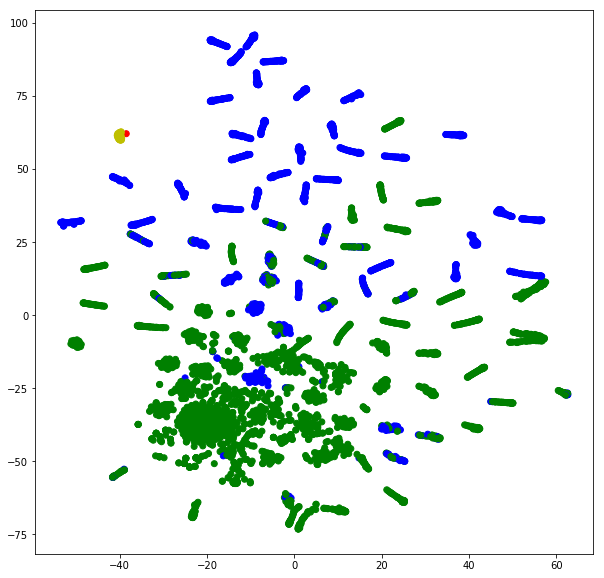

In [9]:
vis_x = tsne_res[:, 0]
vis_y = tsne_res[:, 1]
plt.figure(figsize=(10,10))
plt.scatter(vis_x, vis_y, c=get_colors(train));

In [10]:
def centroids(X, lbls):
    
    centroids = np.zeros((len(np.unique(lbls)), 2))
    
    for l in np.unique(lbls):
        mask = lbls == l
        centroids[l] = np.mean(X[mask], axis=0)
    
    return centroids

X = StandardScaler().fit_transform(tsne_res)
db = DBSCAN(eps=0.085, min_samples=15).fit(X)

unique, counts = np.unique(db.labels_, return_counts=True)
np.unique(counts, return_counts=True)



(array([ 16,  17,  30,  32,  33,  35,  36,  37,  38,  39,  40,  41,  43,
         44,  58,  68,  71,  80, 104, 110, 115, 896]),
 array([ 1,  1,  2,  2,  1,  1,  3,  1,  1,  6, 62,  1,  1,  1,  1,  1,  1,
         4,  1,  1,  1,  1]))

In [13]:
cluster_mask  = (counts <= 157) #& (counts >= 35)
dot_mask = np.array([(l in unique[cluster_mask]) for l in db.labels_])
np.sum(dot_mask)

4096

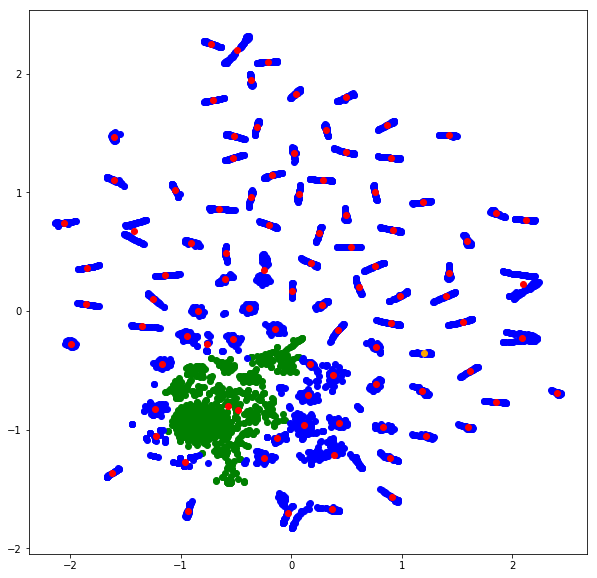

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

# Split meaningful clusters from the noise:
plt.scatter(X[~dot_mask][:, 0], X[~dot_mask][:, 1], c='g')
plt.scatter(X[dot_mask][:, 0], X[dot_mask][:, 1], c='b')

# Add centroids to the picture:
db_centroids = centroids(X, db.labels_)
plt.scatter(db_centroids[cluster_mask][:, 0], 
            db_centroids[cluster_mask][:, 1], c='r')
plt.scatter(db_centroids[~cluster_mask][:, 0], 
            db_centroids[~cluster_mask][:, 1], c='orange')

In [16]:
tsne_no_noise = TSNE(n_components=2, verbose=0, 
                 perplexity=20, early_exaggeration=50, 
                 learning_rate=150).fit_transform(df[dot_mask])

X4 = StandardScaler().fit_transform(tsne_no_noise)

dbf = DBSCAN(eps=0.095, min_samples=25).fit(X4)

uniquef, countsf = np.unique(dbf.labels_, return_counts=True)
np.unique(countsf, return_counts=True)

dbs_maskf  = (countsf <= 45) & (countsf >= 30)
dot_maskf = np.array([(l in uniquef[dbs_maskf]) for l in dbf.labels_])

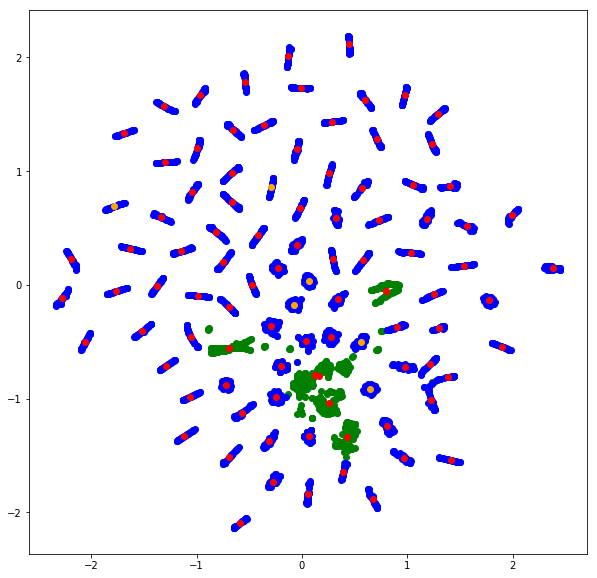

In [17]:
dbf_c = centroids(X4, dbf.labels_)

# Add centroids to the picture:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(X4[~dot_maskf][:, 0], X4[~dot_maskf][:, 1], c='g')
plt.scatter(X4[dot_maskf][:, 0], X4[dot_maskf][:, 1], c='b')

plt.scatter(dbf_c[dbs_maskf][:, 0], dbf_c[dbs_maskf][:, 1], c='r')
plt.scatter(dbf_c[~dbs_maskf][:, 0], dbf_c[~dbs_maskf][:, 1], c='orange')

In [18]:
groups = pd.DataFrame([dbf.labels_[dot_maskf]]).T
groups.index = df.index[dot_mask][dot_maskf]

g_list = []
for g in pd.unique(groups[0]):
    g_list += [list(groups[groups[0] == g].index)]  

len(g_list), len(g_list[0])

(91, 41)

In [33]:
with open('groups.txt', 'w') as file_handler:
    for item in g_list:
        file_handler.write("{},\n".format(item))

In [38]:
def get_column_loc(train, cols):
    locs = []
    for c in cols:
        locs.append(train.columns.get_loc(c))
    return locs

In [43]:
loc_valid = get_column_loc(train, ['266525925', '4b6dfc880', '2cff4bf0c', 'a3382e205', '6488c8200', '547d3135b', 'b46191036', '453128993', '2599a7eb7', '2fc60d4d9', '009319104', 'de14e7687', 'aa31dd768', '2b54cddfd', 'a67d02050', '37aab1168', '939cc02f5', '31f72667c', '6f951302c', '54723be01', '4681de4fd', '8bd53906a', '435f27009', 'f82167572', 'd428161d9', '9015ac21d', 'ec4dc7883', '22c7b00ef', 'd4cc42c3d', '1351bf96e', '1e8801477', 'b7d59d3b5', 'a459b5f7d', '580f5ff06', '39b3c553a', '1eec37deb', '692c44993', 'ce8ce671e', '88ef1d9a8', 'bf042d928'])

In [44]:
loc_invalid = get_column_loc(train, ['4681de4fd', '1e8801477', 'de14e7687', 'aa31dd768', 'ce8ce671e', '8bd53906a', '37aab1168', '580f5ff06', 'ec4dc7883', '4b6dfc880', '31f72667c', '2b54cddfd', 'd428161d9', '2cff4bf0c', '6488c8200', 'a459b5f7d', '939cc02f5', 'b7d59d3b5', 'b46191036', '1eec37deb', '1351bf96e', '009319104', '22c7b00ef', '2599a7eb7', '266525925', '88ef1d9a8', '54723be01', 'bf042d928', '547d3135b', '39b3c553a', '6f951302c', '2fc60d4d9', '453128993', 'f82167572', '9015ac21d', '435f27009', 'a67d02050', 'd4cc42c3d', '692c44993', 'a3382e205']),

In [45]:
print('{}\n'.format(loc_valid))

[2803, 929, 1947, 4888, 2013, 3827, 2166, 4175, 2722, 4026, 2589, 309, 443, 1179, 4472, 834, 2075, 1105, 3898, 3117, 14, 787, 4272, 4176, 1730, 4177, 913, 2638, 4592, 2558, 126, 2102, 2025, 867, 3829, 2267, 4702, 549, 2823, 3529]



In [46]:
print('{}\n'.format(loc_invalid))

([14, 126, 309, 443, 549, 787, 834, 867, 913, 929, 1105, 1179, 1730, 1947, 2013, 2025, 2075, 2102, 2166, 2267, 2558, 2589, 2638, 2722, 2803, 2823, 3117, 3529, 3827, 3829, 3898, 4026, 4175, 4176, 4177, 4272, 4472, 4592, 4702, 4888],)



In [65]:
pattern_812666 = pd.read_csv('../input/pattern-found/pattern_812666.66.csv')

In [54]:
pattern_1964666 = pd.read_csv('../input/pattern-found/pattern_1964666.66.csv')

In [172]:
pattern_812666

,Unnamed: 0,8c5025c23,f52a82e7f,c0b22b847,d75793f21,4cffe31c7,6c2d09fb1,fb42abc0d,206ba1242,62f61f246,...,9108ee25c,b7950e538,a7da4f282,7f0d863ba,b7492e4eb,24c41bd80,fd7b0fc29,621f71db3,26f222d6d,value_count
0,1757,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,39
1,3809,0.00,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,38
2,511,0.00,0.00,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,38
3,3798,0.00,0.00,0.00,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,37
4,625,0.00,0.00,0.00,0.00,812666.66,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,36
5,3303,0.00,0.00,0.00,0.00,0.00,812666.66,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,35
6,4095,0.00,0.00,0.00,0.00,0.00,0.00,812666.66,812666.66,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,34
7,1283,0.00,2480800.00,0.00,0.00,0.00,0.00,0.00,0.00,812666.66,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,32
8,4209,0.00,0.00,2480800.00,0.00,0.00,0.00,0.00,0.00,0.00,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,31
9,1696,0.00,0.00,0.00,2480800.00,0.00,0.00,0.00,0.00,0.00,...,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,812666.66,30


In [1217]:
def count_row(row, tarvalue):
    cnt = 0
    for item in row:
        #print(item, tarvalue)
        if item != tarvalue:
            break
        else:
            cnt += 1
    return cnt

In [1218]:
def count_tarvalue(df, tarvalue):
    cnts = []
    for idx, row in df.iterrows():
        cnts.append(count_row(row, tarvalue))
    return cnts

In [1288]:
def fix_order(tmp, target_value):
    
    def find_first_not(row, tarvalue):
        for value in row:
            if value > 0 and value != target_value:
                #print(row.name, value)
                return value
        return -1
    
    def find_value_idx(row, target):
        for idx, value in enumerate(row):
            if value == target:
                return idx
        return 9999
    
    def compare_with_lag(rowa, rowb, target_value):
        idx_rowa_0 = find_value_idx(rowa, 0)
        idx_rowb_0 = find_value_idx(rowb, 0)
        if idx_rowa_0 != idx_rowb_0:
            #print(rowa.name, idx_rowa_0, rowb.name, idx_rowb_0)
            return idx_rowb_0 < idx_rowa_0
        
        rowa_tar = find_first_not(rowa, target_value)
        idx_b_tara = find_value_idx(rowb, rowa_tar)
        #print('a',rowa_tar, 'in b', idx_b_tara)
        rowb_tar = find_first_not(rowb, target_value)
        idx_a_tarb = find_value_idx(rowa, rowb_tar)
        #print('b',rowb_tar, 'in a', idx_a_tarb)
        return idx_a_tarb < idx_b_tara
    
    def compare_with_shift(rowa, rowb, target_value):
        rowa = rowa.copy()
        rowb = rowb.copy()
        rowa = rowa.replace(target_value, np.NaN)
        rowa = rowa.replace(0, np.NaN)
        rowb = rowb.replace(target_value, np.NaN)
        rowb = rowb.replace(0, np.NaN)
        before = (rowa == rowb).sum()
        shift = (rowa == rowb.shift(1)).sum()
        #print(rowb.name, 'before', before, 'shifted', shift)
        return shift > before
    
    def swap_row_by_index(df, index1, index2):
        print('swap', index1, index2)
        tmp = df.loc[index1].copy()
        df.loc[index1] = df.loc[index2]
        df.loc[index2] = tmp
        df.rename(index={index1:index2,index2:index1},inplace=True)
        return df

    #tmp['count'] = count_tarvalue(tmp, target_value)
    tmp['count'] = (tmp == target_value).sum(axis=1)
    #print(tmp.head())
    count = tmp['count'].value_counts()
    more_cnts = count.loc[count > 1].index.values
    
    print(more_cnts)
    
    for morevalue in more_cnts:
        subset = tmp[tmp['count'] == morevalue]
        #print('more value ', morevalue, 'subset: ', subset.index)
        if len(subset) > 10:
            print('error')
            return
        
        for i in range(len(subset)):
            for j in range((i+1), len(subset)):
                #needswap = compare_with_lag(subset.iloc[i], subset.iloc[j], target_value)
                needswap = compare_with_shift(subset.iloc[i], subset.iloc[j], target_value)
                #print(needswap)
                if needswap:
                    for k in range(i, j):
                        tmp = swap_row_by_index(tmp, subset.index[k], subset.index[j])
                
    tmp.drop('count', axis=1, inplace = True)
    #print(tmp.head())
    return tmp

In [1289]:
def sort_key_columns(tmp, taridx):
    unique, counts = np.unique(tmp.values, return_counts=True)
    unique = list(unique)
    counts = list(counts)
    
    stat = pd.DataFrame()
    for idx, value in enumerate(unique):
        #if value - int(value) > 0:
        if value > 0:
            stat = stat.append({'value':value,'count':counts[idx]}, ignore_index=True)
    #print(stat)
    stat = stat.sort_values(by='count', ascending=False)
    print(stat[:10].reset_index())
    target_value = stat.iloc[taridx].value
    print('target idx {} value {}'.format(taridx,target_value))
    
    sub_rows = pd.DataFrame()
    for idx, row in tmp.iterrows():
        if np.in1d(target_value, row):
            sub_rows = sub_rows.append(row, ignore_index=True)
            
    sub_rows['count'] = (sub_rows == target_value).sum(axis=1)
    sort_row = sub_rows.sort_values('count', ascending=False).drop('count', axis=1)
    
    #sort_row = fix_order(sort_row, target_value)
    
    sub_col = sort_row.T
    sub_col['count'] = (sub_col == target_value).sum(axis=1)
    res = sub_col.sort_values('count').drop('count', axis=1)
    
    res = fix_order(res, target_value).T
    print(res.columns)
    return res


In [1290]:
def calc_right_sequence(train, cols, taridx):
    return sort_key_columns(train[cols], taridx)

In [1384]:
cols = ['266525925','4b6dfc880','2cff4bf0c','a3382e205','6488c8200','547d3135b','b46191036','453128993','2599a7eb7','2fc60d4d9','009319104','de14e7687','aa31dd768','2b54cddfd','a67d02050','37aab1168','939cc02f5','31f72667c','6f951302c','54723be01','4681de4fd','8bd53906a','435f27009','f82167572','d428161d9','9015ac21d','ec4dc7883','22c7b00ef','d4cc42c3d','1351bf96e','1e8801477','b7d59d3b5','a459b5f7d','580f5ff06','39b3c553a','1eec37deb','692c44993','ce8ce671e','88ef1d9a8','bf042d928']

In [1386]:
calc_right_sequence(train, cols, 3)

   index  count        value
0    148  858.0    2000000.0
1     49  795.0     200000.0
2    247  795.0    6000000.0
3    262  716.0    7822000.0
4     64  597.0     366000.0
5     63  552.0     360000.0
6     78  551.0     508000.0
7     10  487.0      22000.0
8    208  392.0    4000000.0
9    484  367.0  156200000.0
target idx 3 value 7822000.0
[ 7 13 30]
swap 2599a7eb7 453128993
swap 37aab1168 a67d02050
Index(['266525925', '4b6dfc880', '2cff4bf0c', 'a3382e205', '6488c8200',
       '547d3135b', 'b46191036', '453128993', '2599a7eb7', '2fc60d4d9',
       '009319104', 'de14e7687', 'aa31dd768', '2b54cddfd', 'a67d02050',
       '37aab1168', '939cc02f5', '31f72667c', '6f951302c', '54723be01',
       '4681de4fd', '8bd53906a', '435f27009', 'f82167572', 'd428161d9',
       '9015ac21d', 'ec4dc7883', '22c7b00ef', 'd4cc42c3d', '1351bf96e',
       '1e8801477', 'b7d59d3b5', 'a459b5f7d', '580f5ff06', '39b3c553a',
       '1eec37deb', '692c44993', 'ce8ce671e', '88ef1d9a8', 'bf042d928'],
      dtype='o

,266525925,4b6dfc880,2cff4bf0c,a3382e205,6488c8200,547d3135b,b46191036,453128993,2599a7eb7,2fc60d4d9,...,1e8801477,b7d59d3b5,a459b5f7d,580f5ff06,39b3c553a,1eec37deb,692c44993,ce8ce671e,88ef1d9a8,bf042d928
15,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
28,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
4,0.0,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
27,0.0,0.0,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
5,50000000.0,0.0,0.0,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
21,426000.0,50000000.0,0.0,0.0,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
30,0.0,426000.0,50000000.0,0.0,0.0,160000.0,3370000.0,7822000.0,7822000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
11,44600000.0,220000.0,0.0,426000.0,50000000.0,0.0,0.0,160000.0,3370000.0,7822000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
31,0.0,44600000.0,220000.0,0.0,426000.0,50000000.0,0.0,0.0,160000.0,3370000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0
14,0.0,0.0,44600000.0,220000.0,0.0,426000.0,50000000.0,0.0,0.0,160000.0,...,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0,7822000.0


In [1365]:
groups.shape

(3574, 1)

In [1366]:
groups['x'] = X4[dot_maskf][:, 0]
groups['y'] = X4[dot_maskf][:, 1]
groups.columns = ['group', 'x', 'y']

In [1367]:
def align_m(v1,v2):
    #Returns rotation matrix to align v1 to v2:
    
    # Unit vectors:
    x1, y1 = v1/np.sqrt(np.dot(v1,v1))
    x2, y2 = v2/np.sqrt(np.dot(v2,v2))
    
    #Cos of the angle between two vectors:
    cosv = x1*x2+y1*y2
    
    #Sin of the angle between two vectors:
    sinv = x1*y2-x2*y1
    
    #Rotation
    rotation_matrix = np.matrix([[cosv, -sinv],[sinv, cosv]])  
    
    return rotation_matrix

def direction(a):
    #Returns direction of a group:
    
    rng = np.max(a, axis=0) - np.min(a, axis=0)
    if rng[0] > rng[1]:
        a = a[a[:, 0].argsort()]
    else:
        a = a[a[:, 1].argsort()]
    
    return a[-1] - a[0]

In [1368]:
for g in groups['group'].unique():
    
    # Extract dots:
    t_dots = np.copy(groups[groups['group']==g].iloc[:,1:])

    # Find center of the group:
    t_center = np.mean(t_dots, axis=0)

    # Find direction of the goup and calculate rotation matrix:
    rotate = align_m(direction(t_dots),[1,0])

    # Rotate all dots:
    for i, d in enumerate(t_dots - t_center):
        t_dots[i] = (rotate*np.matrix(d).T).A1 + t_center

    # Save rotated dots in df:
    groups.loc[groups[groups['group']==g].index, ['x','y']] = t_dots

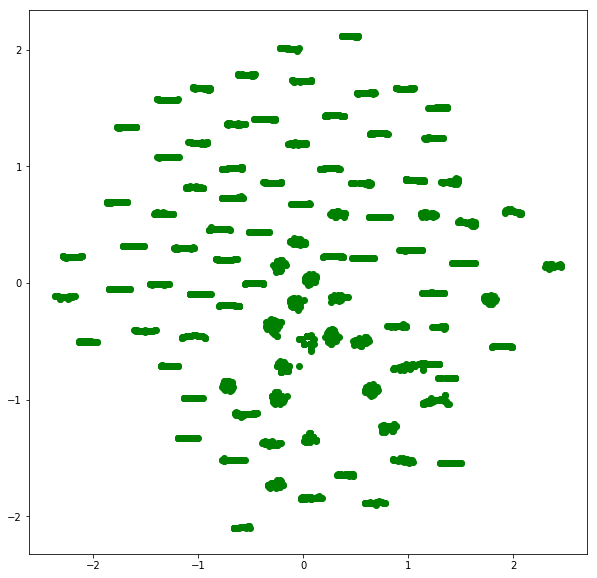

In [1369]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(groups['x'], groups['y'], c='g')

In [1370]:
#Save the labels, we'll use them a lot:
grps = groups['group'].unique()

#Array to hold standard deviations:
xy_std = np.zeros((len(grps), 2))

# Find standard deviations for every group:
for i, g in enumerate(grps):
    xy_std[i] = groups[groups['group']==g].describe()[['x','y']].loc['std',:]

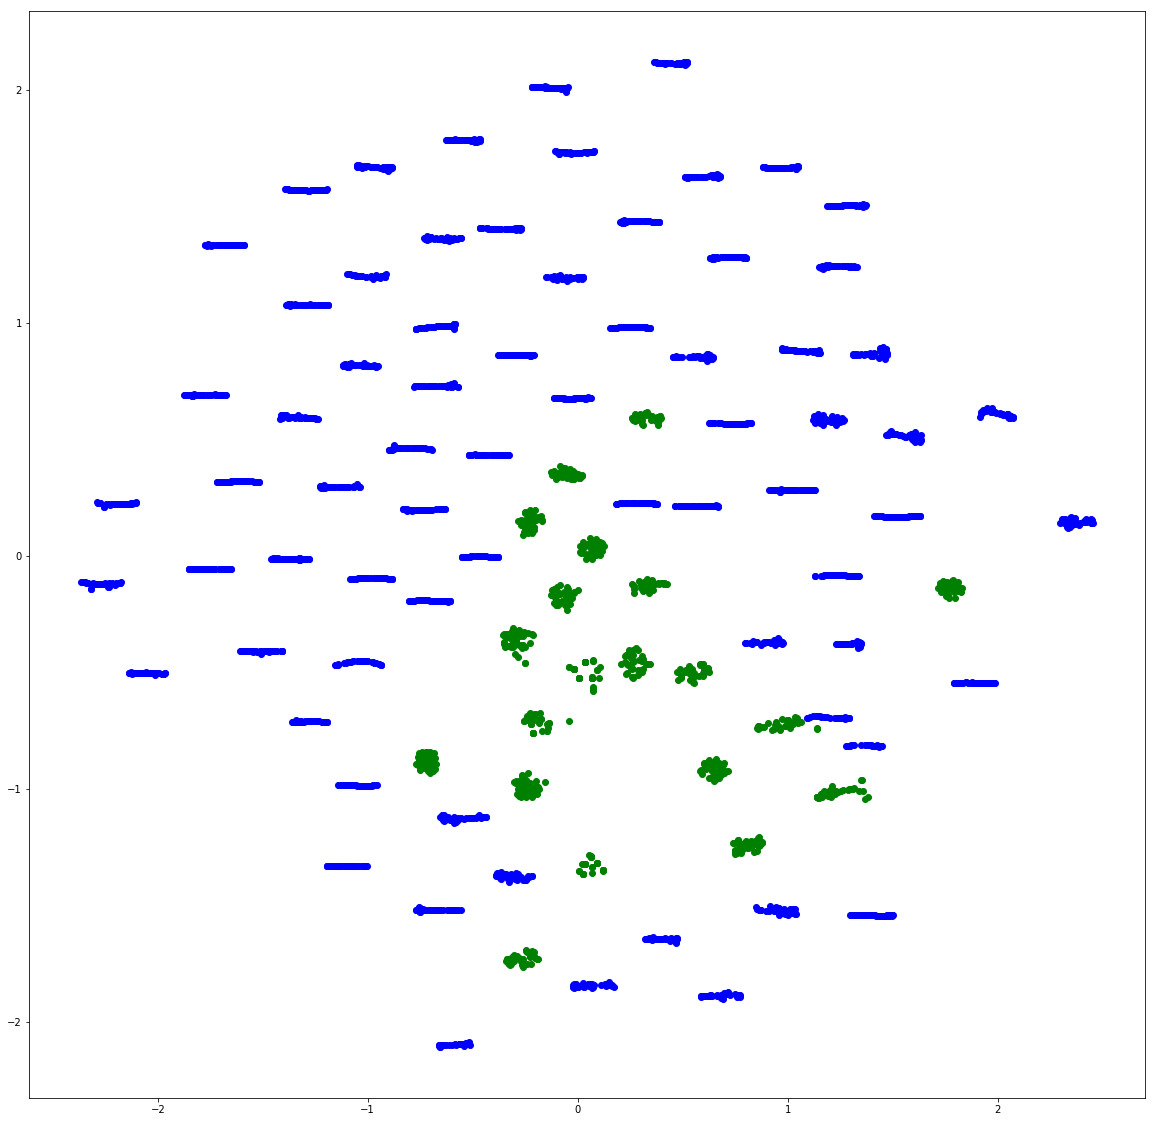

In [1371]:
# Mask groups that have standard deviations considerably higher than the mean:
k = 1.5
std_mask = xy_std[:,1] < xy_std.mean(axis=0)[1]*k

# Mask dots, plot dots:
dots_std_mask = groups['group'].apply(lambda x: x in grps[std_mask])

fig, ax = plt.subplots(figsize=(20, 20))

plt.scatter(groups[~dots_std_mask]['x'], groups[~dots_std_mask]['y'], c='g')
plt.scatter(groups[dots_std_mask]['x'], groups[dots_std_mask]['y'], c='b')

In [1372]:
std_mask 

array([ True, False, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True])

In [1374]:
grps

array([ 4,  0,  2,  3,  5,  6,  7,  8,  9, 10, 34, 11, 12, 13, 15, 16, 65,
       69, 17, 18, 19, 20, 70, 21, 62, 22, 23, 93, 24, 29, 25, 26, 27, 28,
       30, 48, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 47, 46, 49,
       50, 51, 87, 64, 52, 53, 54, 55, 71, 56, 57, 58, 73, 94, 60, 61, 78,
       63, 89, 66, 77, 67, 68, 85, 74, 75, 83, 72, 76, 79, 80, 81, 82, 84,
       91, 86, 88, 90, 92, 95])

In [1376]:
std_mask

array([ True, False, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True])

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466,count
0,38000000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,0,0,0,0,0
1,600000.00,0.0,0,0.0,0,0,0,0,0,2200000.00,...,0.0,0.0,0,0,0,0,0,0,0,0
2,10000000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,0,0,0,0,0
3,2000000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,0,0,0,0,0
4,14400000.00,0.0,0,0.0,0,0,0,0,0,2000000.00,...,0.0,0.0,0,0,0,0,0,0,0,0
5,2800000.00,0.0,0,0.0,0,0,0,0,0,17020000.00,...,5600000.0,20000000.0,0,0,0,0,0,0,11000,0
6,164000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,40000,0,0,0,0
7,600000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,0,0,0,0,0
8,979000.00,0.0,0,0.0,0,0,0,0,0,58000.00,...,0.0,4000000.0,0,0,0,0,0,0,0,0
9,460000.00,0.0,0,0.0,0,0,0,0,0,0.00,...,0.0,0.0,0,0,0,0,0,0,400000,0
